In [1]:
from pathlib import Path, PosixPath
import pandas.plotting
import sys
import cv2 as cv
print(sys.version)
import tensorflow as tf 
#import git # pip install GitPython
import os
import gc
import matplotlib.pyplot as plt # pip install matplotlib
import numpy as np
import time
import pandas as pd
import random as rnd
from tensorflow.python import debug as tf_debug

import gspread
from oauth2client.service_account import ServiceAccountCredentials

3.7.5 (default, Oct 25 2019, 15:51:11) 
[GCC 7.3.0]


/home/oli/miniconda3/envs/tensorflow114/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/oli/miniconda3/envs/tensorflow114/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/oli/miniconda3/envs/tensorflow114/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/oli/miniconda3/envs/tenso

In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
print("=====>GPU Available: ", tf.test.is_gpu_available())
tf.debugging.set_log_device_placement(True)
tf.config.experimental.list_physical_devices('GPU')
#tf.enable_eager_execution()
#tf.config.gpu_options.allow_growth = True 
#tf.config.experimental.set_memory_growth( True)
print(tf.version.GIT_VERSION, tf.version.VERSION)

=====>GPU Available:  True
v1.14.0-rc1-22-gaf24dc9 1.14.0


## Config

In [4]:
#Log Data
print('Modification:')
modification = input() # Was wurde verändert
print('User:')
user = input()#git.util.get_user_id() # Bearbeiter, Sollte automatisch gelesen werden 
try:
    repo = git.Repo()
    branch = repo.active_branch # Projekt, Sollte automatisch gelesen werden
    lastCommit = repo.head.commit.hexsha #"ca324dadsa" # Stand, Sollte automatisch gelesen werden
except:
    print('Branch:')
    
    branch = input()
    lastCommit = ''
env = "hal9k" # Test umgebung

Modification:

User:

Branch:



In [5]:
# Model Config
samplesize = 1000 # Datensatz
split = 0.8  # Testdatensatz in % => 0.8 = 80% testdata
BATCH_SIZE = 80
IMG_HEIGHT = 224
IMG_WIDTH = 224
AUTOTUNE = tf.data.experimental.AUTOTUNE

## Load Images

replaced with the code form Helena

In [6]:
def loadImg(paths): 
    images = {}
    for p in paths:
        img = cv.imread(str(p))
        img2= cv.resize(img,dsize=(IMG_HEIGHT,IMG_WIDTH), interpolation = cv.INTER_CUBIC)
        #Numpy array
        images[p.stem] = np.asarray(img2)
    return images

## Format Labels / Classes /  Images

In [8]:
## Get Classes form Folder
data_dir = Path(os.path.join(Path.cwd(), '../Pictures/Pictures_Bicycles'))
image_count = len(list(data_dir.glob('*/*.jpg')))
CLASS_NAMES = []
for f in np.array([item.name for item in data_dir.glob('Training/*')]):
    name = f.split('_')[0]
    if name not in CLASS_NAMES :
        CLASS_NAMES.append(name)
print (CLASS_NAMES)



def createBatches(l, n):
    # looping till length l 
    nl = []
    for i in range(0, len(l), n):  
        nl.append(l[i:i + n]) 
    return nl

def train_val_split(keys: list): ## Uses split form model config
    train = int(len(keys)*split)
    print (f'Trainsize: {train}')
    return keys[:train], keys[train:]

def getLabels(keys):
    labels = []
    for path in keys:
        if str(path).startswith('uni'):
            folder = str(path).split('_')[0]
        else:
            folder = str(path).split('_')[0] # 0 = manifacturer, 1 = type
        labels.append(float(CLASS_NAMES.index(folder)))
    return labels

def getImages(img, keys):
    images = []
    for k in keys:
        images.append(img[k])
    return images


['trek', 'canyon', 'unicycle', 'cube', 'giant', 'cannondale']


In [11]:
def prepareDataset(path, train:bool=False):
    # Prepare list with Image Paths
    paths = list(path.glob('*.jpg'))
    
    ## Load Images
    raw_images = loadImg(paths)
    
    if train:
        # Gen Train and Test Dataset
        train_keys = list(raw_images.keys()) 
        rnd.shuffle(train_keys) ## Suffle Traings dataset
        train, val = train_val_split(train_keys) # Spilt dataset for train and validation
        # Change dict to list 
        train_labels = getLabels(train)
        train_images = getImages(raw_images, train)
        val_labels = getLabels(val)
        val_images = getImages(raw_images, val)

        print(f'Train {len(train_labels)}, {len(train_images)};  Val {len(val_labels)} {len(val_images)};')

        return (createBatches(train_images, BATCH_SIZE), createBatches(train_labels,BATCH_SIZE)), (createBatches(val_images, int(BATCH_SIZE*(1.05-split))), createBatches(val_labels,int(BATCH_SIZE*(1.05-split))))
    else:
        #Gen Test Dataset
        test = list(raw_images.keys())
        test_labels = getLabels(test)
        test_images = getImages(raw_images, test)

        print(f'Test {len(test_labels)}, {len(test_images)}')
        return (test_images, test_labels), None

In [12]:
train, val = prepareDataset(Path(os.path.join(data_dir, 'Training')), True)

Trainsize: 340
Train 340, 340;  Val 85 85;


In [13]:
print(f'{len(train)} {len(train[0])}, {len(val)} {len(val[0])}')

2 5, 2 5


## TF Code

In [14]:
### Your Code
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
])
model.summary()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
## Start Timer 
start = time.time()
for n in range(1):
    print(f'Batch: {n}')
    # Train
    tibatch = [train[0][n]]
    tlbatch = [train[1][n]]
    model.fit(tibatch, tlbatch, epochs=10, shuffle=True, steps_per_epoch=BATCH_SIZE)

    #val
    vibatch = [val[0][n]]
    vlbatch = [val[1][n]]
    test_loss, test_acc = model.evaluate(vibatch, vlbatch, verbose=2, steps=5)

## End Timer
end = time.time()
runtime = end-start
maxAcc = test_acc
maxLoss = test_loss

print('\nTest accuracy: {}, \nRuntime: {}'.format(test_acc, runtime))

# Save model 
model.save(os.path.join(Path.cwd(),'savedModel.h5'))

## Only way to clean gpu mem but kills tensorflow too, pls add when run over night and restart the notebook the next day
#from numba import cuda
#cuda.select_device(0)
#cuda.close()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               25690240  
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                2064      
____

In [ ]:
# Just needed when the last 3 lines where executed
from pathlib import Path, PosixPath
import pandas.plotting
import os
import tensorflow as tf 
import matplotlib.pyplot as plt
import numpy as np

## Predict / Display Images

In [7]:
def showBatch(image_batch, label_batch, prediction=None):
    plt.figure(figsize=(20,20))
    for n in range(20):
        ax = plt.subplot(5,5,n+1)
        ax.imshow(image_batch[n])
        if prediction is not None:
            plt.title(f'{CLASS_NAMES[int(label_batch[n])]} | {CLASS_NAMES[int(np.argmax(prediction[n]))]}')
        else:
            plt.title(f'{CLASS_NAMES[int(label_batch[n])]}')
        ax.axis('off')
    plt.show()
        

Test 85, 85


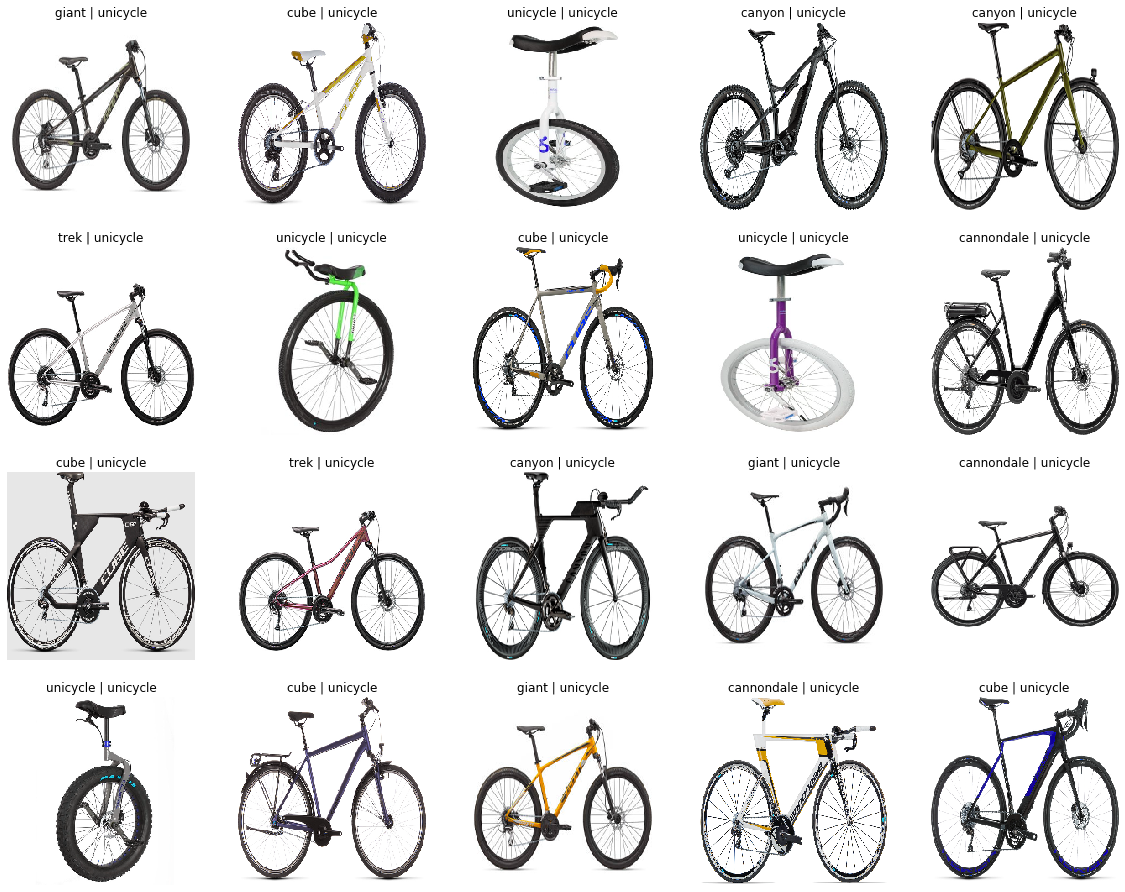

In [18]:
test, x = prepareDataset(Path(os.path.join(data_dir, 'Test')))
                      
model = tf.keras.models.load_model(os.path.join(Path.cwd(),'savedModel.h5'))

## pick 20 random images form trainset
test_images, test_labels = [], []
ids = rnd.sample(range(0, len(test[0])), 20)
for i in range(20):
    test_images.append(test[0][ids[i]])
    test_labels.append(test[1][ids[i]])

ibatch = [test_images]
predictions = model.predict(ibatch, steps=2)
showBatch(test_images, test_labels, predictions)

In [19]:
#for pred in predictions:
preds = list(np.argmax(pred) for pred in predictions)
print(preds)
validatedTestAcc = 0
for i in range(len(test_labels)):
    print(f'Real: {test_labels[i]} => Est: {preds[i]}, Value: {max(predictions[i])}')
    if int(test_labels[i]) == preds[i]:
        validatedTestAcc += 1
validatedTestAcc = validatedTestAcc / len(test_labels)

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Real: 4.0 => Est: 2, Value: 0.22116619348526
Real: 3.0 => Est: 2, Value: 0.22116619348526
Real: 2.0 => Est: 2, Value: 0.22116619348526
Real: 1.0 => Est: 2, Value: 0.22116619348526
Real: 1.0 => Est: 2, Value: 0.22116619348526
Real: 0.0 => Est: 2, Value: 0.22116619348526
Real: 2.0 => Est: 2, Value: 0.22116619348526
Real: 3.0 => Est: 2, Value: 0.22116619348526
Real: 2.0 => Est: 2, Value: 0.22116619348526
Real: 5.0 => Est: 2, Value: 0.22116619348526
Real: 3.0 => Est: 2, Value: 0.22116619348526
Real: 0.0 => Est: 2, Value: 0.22116619348526
Real: 1.0 => Est: 2, Value: 0.22116619348526
Real: 4.0 => Est: 2, Value: 0.22116619348526
Real: 5.0 => Est: 2, Value: 0.22116619348526
Real: 2.0 => Est: 2, Value: 0.22116619348526
Real: 3.0 => Est: 2, Value: 0.22116619348526
Real: 4.0 => Est: 2, Value: 0.22116619348526
Real: 5.0 => Est: 2, Value: 0.22116619348526
Real: 3.0 => Est: 2, Val

# Free Resources, run before closing the tab/file

In [22]:
from numba import cuda
cuda.select_device(0)
cuda.close()

## Log

In [20]:
# use creds to create a client to interact with the Google Drive API
scope = ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']
creds = ServiceAccountCredentials.from_json_keyfile_name(os.path.join(Path.home(),'client-secret.json'), scope)
client = gspread.authorize(creds)

# File and WorkSheet 
sheet = client.open("Model Evaluation").sheet1

# Read row form sheet
# readval = sheet.row_values(1)

sheet.append_row([modification, branch, user, lastCommit, str(samplesize), str(split), env, str(runtime), str(maxAcc), str(maxLoss), str(validatedTestAcc)])

FileNotFoundError: [Errno 2] No such file or directory: '/home/oli/client-secret.json'